**Nama  : Khilda Fitria Nurultsani**<br>
**Nim   : 211351070**<br>
**Kelas : TIF Pagi B**

# Import Library Yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mlxtend.frequent_patterns import association_rules, apriori
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khildafn07","key":"e8d799521732077f3bf4d56304a36257"}'}

# import Dataset

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d sulmansarwar/transactions-from-a-bakery

  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 56.4MB/s]


In [5]:
!mkdir transactions-from-a-bakery
!unzip transactions-from-a-bakery -d transactions-from-a-bakery
!ls transactions-from-a-bakery

Archive:  transactions-from-a-bakery.zip
  inflating: transactions-from-a-bakery/BreadBasket_DMS.csv  
BreadBasket_DMS.csv


In [6]:
bakery = pd.read_csv('/content/transactions-from-a-bakery/BreadBasket_DMS.csv')

# Data Discovery

In [7]:
bakery.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [8]:
bakery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


In [9]:
bakery.shape

(21293, 4)

In [10]:
bakery.isnull().sum()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

In [11]:
bakery.columns

Index(['Date', 'Time', 'Transaction', 'Item'], dtype='object')

In [12]:
bakery['Item'].value_counts().to_dict()

{'Coffee': 5471,
 'Bread': 3325,
 'Tea': 1435,
 'Cake': 1025,
 'Pastry': 856,
 'NONE': 786,
 'Sandwich': 771,
 'Medialuna': 616,
 'Hot chocolate': 590,
 'Cookies': 540,
 'Brownie': 379,
 'Farm House': 374,
 'Muffin': 370,
 'Juice': 369,
 'Alfajores': 369,
 'Soup': 342,
 'Scone': 327,
 'Toast': 318,
 'Scandinavian': 277,
 'Truffles': 193,
 'Coke': 185,
 'Spanish Brunch': 172,
 'Fudge': 159,
 'Baguette': 152,
 'Jam': 149,
 'Tiffin': 146,
 'Mineral water': 136,
 'Jammie Dodgers': 125,
 'Chicken Stew': 123,
 'Hearty & Seasonal': 107,
 'Salad': 99,
 'Frittata': 81,
 'Smoothies': 77,
 'Keeping It Local': 63,
 'The Nomad': 58,
 'Focaccia': 54,
 'Vegan mincepie': 54,
 'Bakewell': 48,
 'Tartine': 47,
 'Afternoon with the baker': 44,
 'Extra Salami or Feta': 38,
 'Art Tray': 38,
 'Eggs': 28,
 'Granola': 28,
 'Tshirt': 21,
 'My-5 Fruit Shoot': 18,
 "Ella's Kitchen Pouches": 17,
 'Vegan Feast': 16,
 'Crisps': 14,
 'Dulce de Leche': 13,
 "Valentine's card": 13,
 'Kids biscuit': 12,
 'Duck egg': 12,

# Exploratory Data Analysis

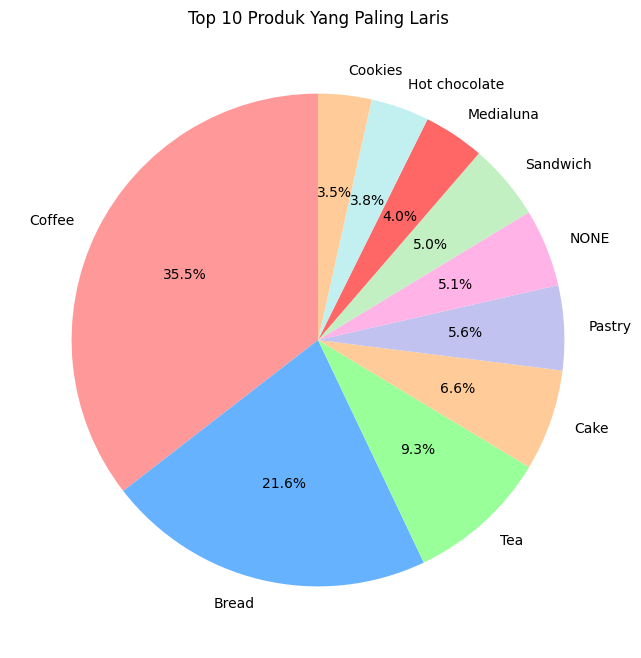

In [13]:
top_item = bakery['Item'].value_counts().nlargest(10)
custom_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#ff6666', '#c2f0f0', '#ffcc99']

plt.figure(figsize=(8, 8))
plt.pie(top_item, labels=top_item.index, autopct='%1.1f%%', startangle=90, colors=custom_colors)
plt.title('Top 10 Produk Yang Paling Laris')
plt.show()

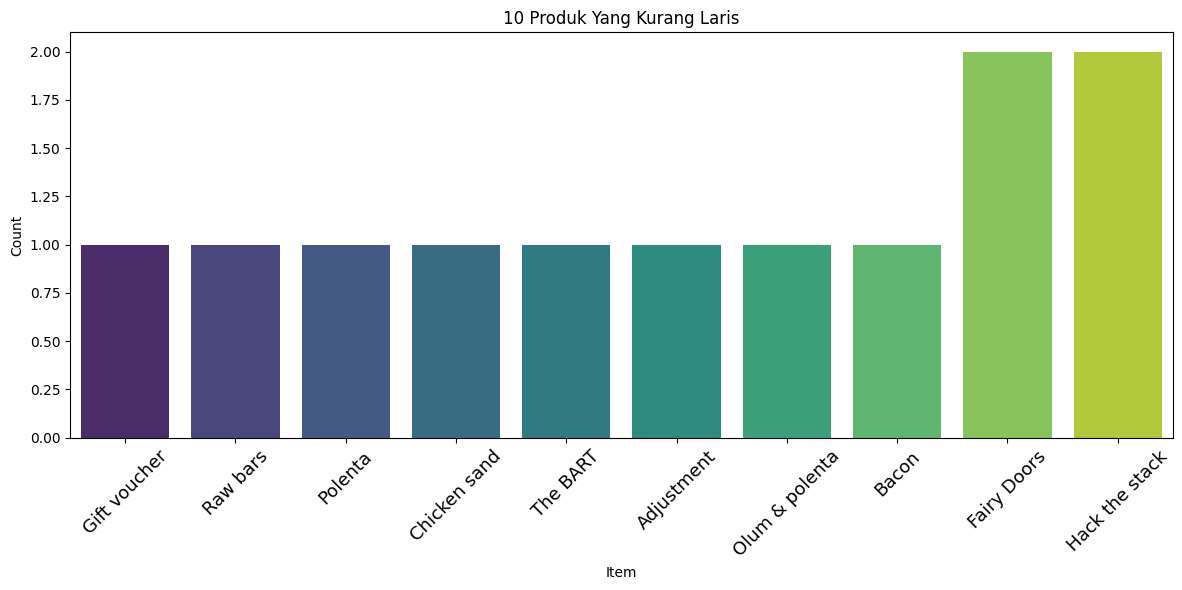

In [14]:
bottom_item = bakery['Item'].value_counts().nsmallest(10)

plt.figure(figsize=(12, 6))
sns.countplot(x='Item', data=bakery, order=bottom_item.index, palette='viridis')
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('10 Produk Yang Kurang Laris')
plt.xticks(size=13, rotation=45)
plt.tight_layout()

plt.show()

# Data Preparation

In [15]:
# Menggabungkan Kolom Date dan Time
bakery['Datetime'] = pd.to_datetime(bakery['Date'] + ' ' + bakery['Time'], format='%Y-%m-%d %H:%M:%S')

In [16]:
bakery = bakery.drop(['Date','Time'],axis=1)
bakery.head()

,Transaction,Item,Datetime
0,1,Bread,2016-10-30 09:58:11
1,2,Scandinavian,2016-10-30 10:05:34
2,2,Scandinavian,2016-10-30 10:05:34
3,3,Hot chocolate,2016-10-30 10:07:57
4,3,Jam,2016-10-30 10:07:57


In [17]:
# Memecah Datetime ke Bulan,Hari, dan Jam
bakery['Datetime'] = pd.to_datetime(bakery['Datetime'], format= "%Y-%m-%d %H:%M")

In [18]:
bakery["Datetime"].dtype

dtype('<M8[ns]')

In [19]:
bakery["month"] = bakery['Datetime'].dt.month
bakery["day"] = bakery['Datetime'].dt.day
bakery["hour"] = bakery['Datetime'].dt.hour
bakery.head()

,Transaction,Item,Datetime,month,day,hour
0,1,Bread,2016-10-30 09:58:11,10,30,9
1,2,Scandinavian,2016-10-30 10:05:34,10,30,10
2,2,Scandinavian,2016-10-30 10:05:34,10,30,10
3,3,Hot chocolate,2016-10-30 10:07:57,10,30,10
4,3,Jam,2016-10-30 10:07:57,10,30,10


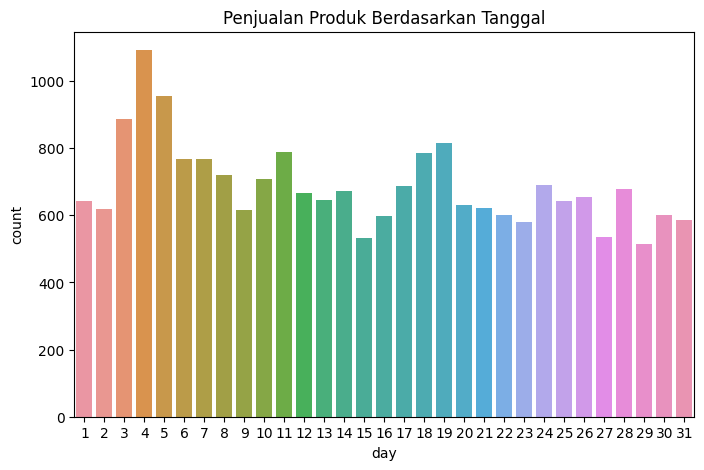

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(x='day',data=bakery)
plt.title('Penjualan Produk Berdasarkan Tanggal')
plt.show()

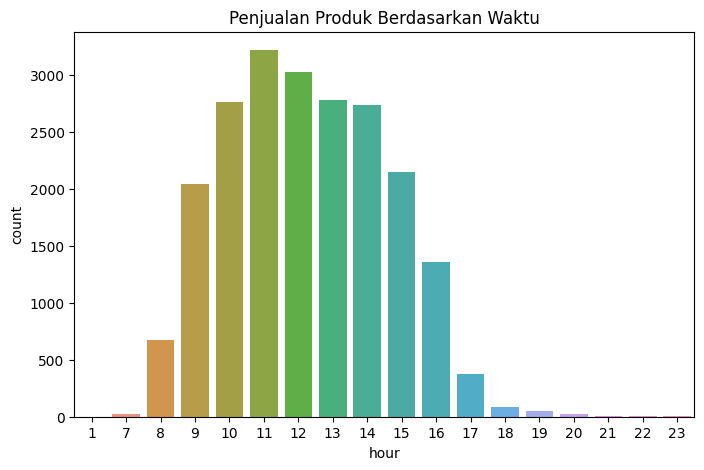

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='hour',data=bakery)
plt.title('Penjualan Produk Berdasarkan Waktu')
plt.show()

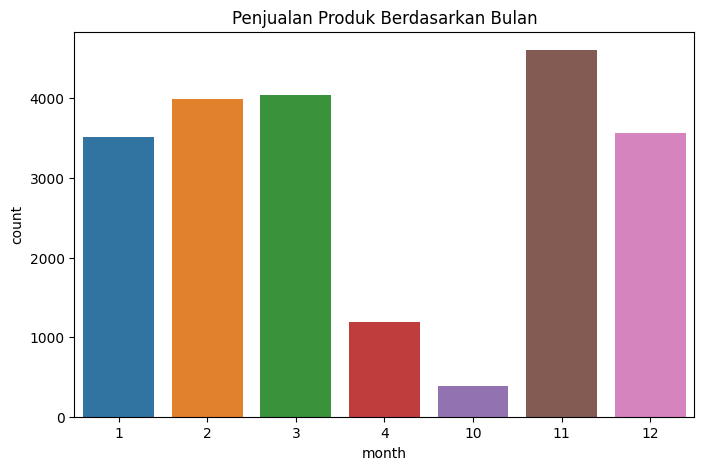

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='month',data=bakery)
plt.title('Penjualan Produk Berdasarkan Bulan')
plt.show()

In [23]:
bakery['Item'] = bakery['Item'].apply(lambda item: item.lower())

In [24]:
bakery['Item'] = bakery['Item'].apply(lambda item: item.strip())

In [25]:
bakery = bakery[["Transaction", "Item"]].copy()
bakery.head(10)

,Transaction,Item
0,1,bread
1,2,scandinavian
2,2,scandinavian
3,3,hot chocolate
4,3,jam
5,3,cookies
6,4,muffin
7,5,coffee
8,5,pastry
9,5,bread


# Modeling

In [26]:
item_count = bakery.groupby(["Transaction", "Item"])["Item"].count().reset_index(name="Count")
item_count.head(10)

,Transaction,Item,Count
0,1,bread,1
1,2,scandinavian,2
2,3,cookies,1
3,3,hot chocolate,1
4,3,jam,1
5,4,muffin,1
6,5,bread,1
7,5,coffee,1
8,5,pastry,1
9,6,medialuna,1


In [27]:
item_count_pivot = item_count.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
print("ukuran dataset : ", item_count_pivot.shape)
item_count_pivot.head(5)

ukuran dataset :  (9531, 95)


Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
item_count_pivot = item_count_pivot.astype("int32")
item_count_pivot.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
def encode(x):
    if x <=0:
        return 0
    elif x >= 1:
        return 1

item_count_pivot = item_count_pivot.applymap(encode)
item_count_pivot.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print("ukuran dataset : ", item_count_pivot.shape)
print("jumlah transaksi : ", item_count_pivot.shape[0])
print("jumlah item : ", item_count_pivot.shape[1])

ukuran dataset :  (9531, 95)
jumlah transaksi :  9531
jumlah item :  95


In [31]:
support = 0.01
frequent_items = apriori(item_count_pivot, min_support=support, use_colnames=True)
frequent_items.sort_values("support", ascending=False).head(10)

,support,itemsets
6,0.475081,(coffee)
2,0.324940,(bread)
27,0.141643,(tea)
4,0.103137,(cake)
35,0.089393,"(bread, coffee)"
20,0.085510,(pastry)
19,0.079005,(none)
22,0.071346,(sandwich)
16,0.061379,(medialuna)
12,0.057916,(hot chocolate)


In [32]:
metric = "lift"
min_treshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_treshold)[["antecedents","consequents","support","confidence","lift"]]
rules.sort_values('confidence', ascending=False,inplace=True)
rules.head(15)

,antecedents,consequents,support,confidence,lift
32,(toast),(coffee),0.023502,0.704403,1.482699
31,(spanish brunch),(coffee),0.010807,0.598837,1.260494
18,(medialuna),(coffee),0.034939,0.569231,1.198175
24,(pastry),(coffee),0.047214,0.552147,1.162216
0,(alfajores),(coffee),0.019515,0.540698,1.138116
16,(juice),(coffee),0.020460,0.534247,1.124537
22,(none),(coffee),0.042073,0.532537,1.120938
26,(sandwich),(coffee),0.037981,0.532353,1.120551
6,(cake),(coffee),0.054349,0.526958,1.109196
29,(scone),(coffee),0.017941,0.522936,1.100729


# Visualisasi Hasil Algoritma

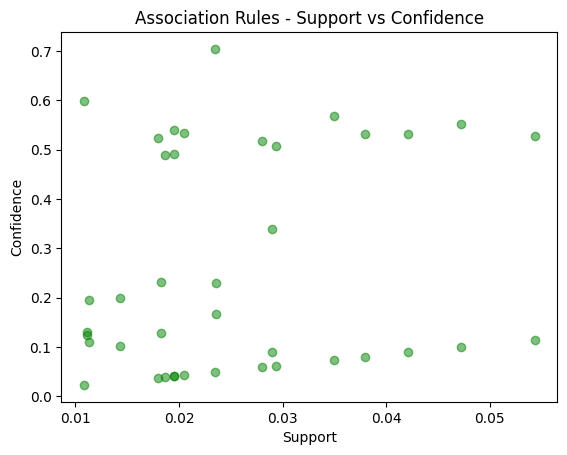

In [33]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, color='green')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules - Support vs Confidence')
plt.show()

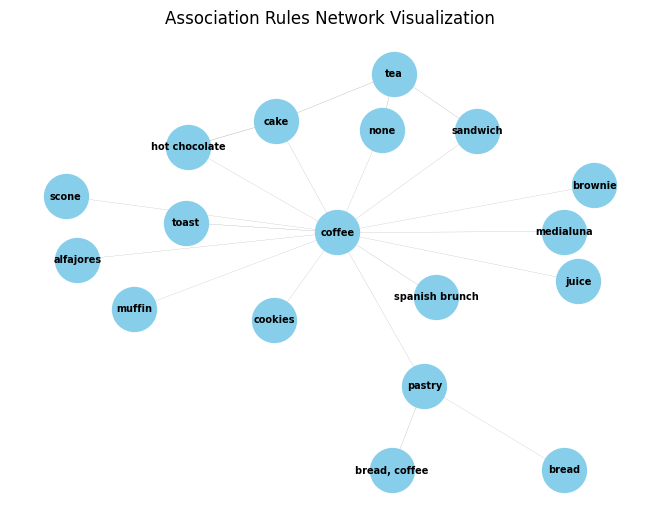

In [43]:
# Network visualization for association rules
G = nx.Graph()

for index, row in rules.iterrows():
    G.add_edge(', '.join(row['antecedents']), ', '.join(row['consequents']), weight=row['lift'])

# Set the layout
pos = nx.spring_layout(G)

# Draw the network
nx.draw(G, pos, with_labels=True, font_size=7, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', edge_color='gray', width=[d['weight'] * 0.1 for u, v, d in G.edges(data=True)])
plt.title('Association Rules Network Visualization')
plt.show()